In [1]:
import os
import random
import numpy as np 
import pandas as pd
from tqdm import tqdm 
from PIL import Image
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms 
from transformers import ViTFeatureExtractor
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import cross_entropy
from transformers import BertTokenizer, BertModel, ViTModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class ChestXrayDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_dir , self.data_frame['filename'].iloc[index])
        caption = self.data_frame['impression'].iloc[index]

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, caption

In [3]:
image_dir = "Dataset\Indiana University - Chest X-Rays\images\images"
image_caption_csv_path = "Dataset\Indiana University - Chest X-Rays\indiana_chest_xray_captions.csv"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = ChestXrayDataset(csv_file=image_caption_csv_path, img_dir=image_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

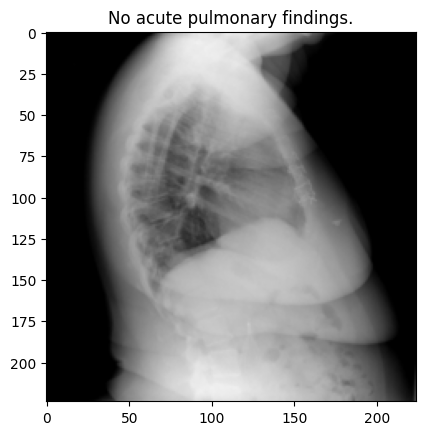

In [4]:
image, caption = dataset.__getitem__(3)

image = image.permute(1, 2, 0).numpy()
plt.imshow(image)
plt.title(f"{caption}")
plt.show()

In [ ]:
# class MaskedAutoencoder(nn.Module):
#     def __init__(self, vit_model, hidden_size, patch_size, num_decoder_layers=8):
#         super(MaskedAutoencoder, self).__init__()
#         self.vit = vit_model
#         self.hidden_size = hidden_size
#         self.patch_size = patch_size
        
#         # Define an 8-layer transformer for decoding
#         decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=8)
#         self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
#         # Linear layer to reconstruct patches from hidden representations
#         self.reconstruction_layer = nn.Linear(hidden_size, patch_size * patch_size * 3)  # (hidden_size -> patch_size * patch_size * channels)
        
#     def forward(self, x, mask_probability=0.15):
#         # Extract patch embeddings from the ViT model
#         vit_output = self.vit(pixel_values=x)
#         patch_embeddings = vit_output.last_hidden_state[:, 1:, :]  # Remove class token
        
#         # Apply masking to patch embeddings
#         masked_embeddings, mask = self.apply_mask(patch_embeddings, mask_probability)
        
#         # Decode the masked patches using the transformer decoder
#         # We pass the original (unmasked) patch embeddings as "memory" for the decoder
#         decoded_embeddings = self.decoder(masked_embeddings, patch_embeddings)
        
#         # Reconstruct the masked patches
#         reconstructed_patches = self.reconstruction_layer(decoded_embeddings)
        
#         return reconstructed_patches, mask

#     def apply_mask(self, x, mask_probability):
#         """
#         Masks a portion of patches and retains both masked and unmasked patches separately.
#         """
#         batch_size, num_patches, hidden_size = x.shape
#         mask = (torch.rand(batch_size, num_patches, device=x.device) < mask_probability)  # 15% masking
        
#         # Replace masked patches with a placeholder (zeros) in the input to the decoder
#         masked_embeddings = x.clone()
#         masked_embeddings[mask] = 0  # Placeholder for masked patches

#         return masked_embeddings, mask

#     def patchify(self, x):
#         """
#         Reshape the image into patches (B, C, H, W) -> (B, num_patches, patch_size*patch_size*C)
#         """
#         B, C, H, W = x.shape
#         x = x.reshape(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
#         x = x.permute(0, 2, 4, 3, 5, 1).reshape(B, -1, self.patch_size * self.patch_size * C)
#         return x


# def masked_loss(mae_model, reconstructed_patches, original_images, mask):
#     """
#     Calculate L2 loss only on masked patches.
#     """
#     # Convert the original image into patches
#     original_patches = mae_model.patchify(original_images)
    
#     # Expand the mask to match the shape of original_patches along the channel dimension
#     mask = mask.unsqueeze(-1).expand_as(original_patches)
    
#     # Apply mask to both original and reconstructed patches to calculate loss only for masked patches
#     masked_original = original_patches * mask
#     masked_reconstructed = reconstructed_patches * mask
    
#     # Calculate MSE loss on masked patches
#     loss_fn = nn.MSELoss()
#     loss = loss_fn(masked_reconstructed, masked_original)
    
#     return loss

In [ ]:
# # Initialize ViT model and feature extractor
# vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# # Define image properties
# img_size = 224
# patch_size = 16
# hidden_size = vit_model.config.hidden_size

# # Initialize MAE model
# mae_model = MaskedAutoencoder(vit_model, hidden_size, patch_size)
# mae_model = mae_model.to(device)

# # Initialize DataLoader (assuming dataset is already defined as ChestXrayDataset)
# data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# # Test the model on one batch
# images, _ = next(iter(data_loader))  # Assuming dataset provides images only for simplicity
# images = images.to(device)

# # Forward pass through the model
# with torch.no_grad():
#     reconstructed_patches, mask = mae_model(images, mask_probability=0.15)

# # Calculate loss on the masked patches
# loss = masked_loss(mae_model, reconstructed_patches, images, mask)

# # Output results
# print("Reconstructed Patches Shape:", reconstructed_patches.shape)
# print("Mask Shape:", mask.shape)
# print("Loss on Masked Patches:", loss.item())


In [ ]:
import torch
import torch.nn as nn
from transformers import ViTModel

class MaskedAutoencoder(nn.Module):
    def __init__(self, vit_model, hidden_size, patch_size, num_decoder_layers=8):
        super(MaskedAutoencoder, self).__init__()
        self.vit = vit_model  # 12-layer encoder (Vision Transformer)
        self.hidden_size = hidden_size
        self.patch_size = patch_size
        
        # Define an 8-layer transformer for decoding
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=8)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        # Learnable placeholder embedding for masked patches
        self.mask_token = nn.Parameter(torch.randn(1, 1, hidden_size))
        
        # Linear layer as prediction head to reconstruct pixel values of masked patches
        self.prediction_head = nn.Linear(hidden_size, patch_size * patch_size * 3)  # Map each embedding to pixel values

    def forward(self, x, mask_probability=0.15):
        # Extract patch embeddings from the ViT encoder
        vit_output = self.vit(pixel_values=x)
        patch_embeddings = vit_output.last_hidden_state[:, 1:, :]  # Remove class token
        
        # Apply masking to patch embeddings
        masked_embeddings, mask = self.apply_mask(patch_embeddings, mask_probability)
        
        # Decode the embeddings with context from unmasked patches
        decoded_embeddings = self.decoder(masked_embeddings, patch_embeddings)
        
        # Reconstruct the pixel values of each patch with the prediction head
        reconstructed_patches = self.prediction_head(decoded_embeddings)
        
        return reconstructed_patches, mask

    def apply_mask(self, patch_embeddings, mask_probability):
        """
        Masks a portion of patches by replacing them with a learnable mask token.
        """
        batch_size, num_patches, hidden_size = patch_embeddings.shape
        mask = (torch.rand(batch_size, num_patches, device=patch_embeddings.device) < mask_probability)  # 15% masking
        
        # Replace masked patches with the mask token
        mask_token_expanded = self.mask_token.expand(batch_size, num_patches, hidden_size)
        masked_embeddings = torch.where(mask.unsqueeze(-1), mask_token_expanded, patch_embeddings)

        return masked_embeddings, mask

    def patchify(self, x):
        """
        Reshape the image into patches (B, C, H, W) -> (B, num_patches, patch_size*patch_size*C)
        """
        B, C, H, W = x.shape
        x = x.reshape(B, C, H // self.patch_size, self.patch_size, W // self.patch_size, self.patch_size)
        x = x.permute(0, 2, 4, 3, 5, 1).reshape(B, -1, self.patch_size * self.patch_size * C)
        return x



def masked_loss(mae_model, reconstructed_patches, original_images, mask):
    """
    Calculate L2 loss only on masked patches.
    """
    # Convert the original image into patches
    original_patches = mae_model.patchify(original_images)
    
    # Expand the mask to match the shape of original_patches along the channel dimension
    mask = mask.unsqueeze(-1).expand_as(original_patches)
    
    # Apply mask to both original and reconstructed patches to calculate loss only for masked patches
    masked_original = original_patches * mask
    masked_reconstructed = reconstructed_patches * mask
    
    # Calculate MSE loss on masked patches
    loss_fn = nn.MSELoss()
    loss = loss_fn(masked_reconstructed, masked_original)
    
    return loss


In [14]:
# Initialize ViT model and feature extractor
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Define image properties
img_size = 224
patch_size = 16
hidden_size = vit_model.config.hidden_size

# Initialize MAE model
mae_model = MaskedAutoencoder(vit_model, hidden_size, patch_size)
mae_model = mae_model.to(device)

# Initialize DataLoader (assuming dataset is already defined as ChestXrayDataset)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Test the model on one batch
images, _ = next(iter(data_loader))  # Assuming dataset provides images only for simplicity
images = images.to(device)

# Forward pass through the model
with torch.no_grad():
    reconstructed_patches, mask = mae_model(images, mask_probability=0.15)

# Calculate loss on the masked patches
loss = masked_loss(mae_model, reconstructed_patches, images, mask)

# Output results
print("Reconstructed Patches Shape:", reconstructed_patches.shape)
print("Mask Shape:", mask.shape)
print("Loss on Masked Patches:", loss.item())


Reconstructed Patches Shape: torch.Size([4, 196, 768])
Mask Shape: torch.Size([4, 196])
Loss on Masked Patches: 0.09905155748128891


In [7]:
def train_mim_model(mae_model, data_loader, device, num_epochs=3, learning_rate=1e-4, checkpoint_path="mim_checkpoint.pth"):
    """
    Train the Masked Image Modeling model with checkpointing.

    Parameters:
    - mae_model: MaskedAutoencoder instance
    - data_loader: DataLoader instance with training data
    - device: torch.device, either 'cuda' or 'cpu'
    - num_epochs: int, number of training epochs
    - learning_rate: float, learning rate for optimizer
    - checkpoint_path: str, path to save/load model checkpoint
    """
    optimizer = optim.Adam(mae_model.parameters(), lr=learning_rate)
    
    # Load checkpoint if it exists
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        mae_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch + 1}")

    for epoch in range(start_epoch, num_epochs):
        mae_model.train()
        total_loss = 0
        batch_count = len(data_loader)
        
        for i, (images, _) in enumerate(data_loader):
            # Move images to the correct device
            images = images.to(device)
            
            # Forward pass through the model
            optimizer.zero_grad()
            reconstructed_patches, mask = mae_model(images, mask_probability=0.15)
            
            # Calculate loss on the masked patches
            loss = masked_loss(mae_model, reconstructed_patches, images, mask)
            loss.backward()
            optimizer.step()
            
            # Accumulate loss for reporting
            total_loss += loss.item()

            # Print progress every 10 batches
            if (i + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{batch_count}], Loss: {total_loss / (i + 1):.4f}")
        
        # Average loss for the epoch
        avg_loss = total_loss / len(data_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': mae_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1}")

    print("Training complete.")

In [15]:
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Define image properties
img_size = 224
patch_size = 16
hidden_size = vit_model.config.hidden_size

# Initialize MAE model
mae_model = MaskedAutoencoder(vit_model, hidden_size, patch_size)
mae_model = mae_model.to(device)

# Assuming data_loader is already initialized with ChestXrayDataset
train_mim_model(mae_model, data_loader, device, num_epochs=1, learning_rate=1e-4, checkpoint_path=r"Code\Models\mim_checkpoint.pth")

RuntimeError: Error(s) in loading state_dict for MaskedAutoencoder:
	Missing key(s) in state_dict: "image_encoder.embeddings.cls_token", "image_encoder.embeddings.position_embeddings", "image_encoder.embeddings.patch_embeddings.projection.weight", "image_encoder.embeddings.patch_embeddings.projection.bias", "image_encoder.encoder.layer.0.attention.attention.query.weight", "image_encoder.encoder.layer.0.attention.attention.query.bias", "image_encoder.encoder.layer.0.attention.attention.key.weight", "image_encoder.encoder.layer.0.attention.attention.key.bias", "image_encoder.encoder.layer.0.attention.attention.value.weight", "image_encoder.encoder.layer.0.attention.attention.value.bias", "image_encoder.encoder.layer.0.attention.output.dense.weight", "image_encoder.encoder.layer.0.attention.output.dense.bias", "image_encoder.encoder.layer.0.intermediate.dense.weight", "image_encoder.encoder.layer.0.intermediate.dense.bias", "image_encoder.encoder.layer.0.output.dense.weight", "image_encoder.encoder.layer.0.output.dense.bias", "image_encoder.encoder.layer.0.layernorm_before.weight", "image_encoder.encoder.layer.0.layernorm_before.bias", "image_encoder.encoder.layer.0.layernorm_after.weight", "image_encoder.encoder.layer.0.layernorm_after.bias", "image_encoder.encoder.layer.1.attention.attention.query.weight", "image_encoder.encoder.layer.1.attention.attention.query.bias", "image_encoder.encoder.layer.1.attention.attention.key.weight", "image_encoder.encoder.layer.1.attention.attention.key.bias", "image_encoder.encoder.layer.1.attention.attention.value.weight", "image_encoder.encoder.layer.1.attention.attention.value.bias", "image_encoder.encoder.layer.1.attention.output.dense.weight", "image_encoder.encoder.layer.1.attention.output.dense.bias", "image_encoder.encoder.layer.1.intermediate.dense.weight", "image_encoder.encoder.layer.1.intermediate.dense.bias", "image_encoder.encoder.layer.1.output.dense.weight", "image_encoder.encoder.layer.1.output.dense.bias", "image_encoder.encoder.layer.1.layernorm_before.weight", "image_encoder.encoder.layer.1.layernorm_before.bias", "image_encoder.encoder.layer.1.layernorm_after.weight", "image_encoder.encoder.layer.1.layernorm_after.bias", "image_encoder.encoder.layer.2.attention.attention.query.weight", "image_encoder.encoder.layer.2.attention.attention.query.bias", "image_encoder.encoder.layer.2.attention.attention.key.weight", "image_encoder.encoder.layer.2.attention.attention.key.bias", "image_encoder.encoder.layer.2.attention.attention.value.weight", "image_encoder.encoder.layer.2.attention.attention.value.bias", "image_encoder.encoder.layer.2.attention.output.dense.weight", "image_encoder.encoder.layer.2.attention.output.dense.bias", "image_encoder.encoder.layer.2.intermediate.dense.weight", "image_encoder.encoder.layer.2.intermediate.dense.bias", "image_encoder.encoder.layer.2.output.dense.weight", "image_encoder.encoder.layer.2.output.dense.bias", "image_encoder.encoder.layer.2.layernorm_before.weight", "image_encoder.encoder.layer.2.layernorm_before.bias", "image_encoder.encoder.layer.2.layernorm_after.weight", "image_encoder.encoder.layer.2.layernorm_after.bias", "image_encoder.encoder.layer.3.attention.attention.query.weight", "image_encoder.encoder.layer.3.attention.attention.query.bias", "image_encoder.encoder.layer.3.attention.attention.key.weight", "image_encoder.encoder.layer.3.attention.attention.key.bias", "image_encoder.encoder.layer.3.attention.attention.value.weight", "image_encoder.encoder.layer.3.attention.attention.value.bias", "image_encoder.encoder.layer.3.attention.output.dense.weight", "image_encoder.encoder.layer.3.attention.output.dense.bias", "image_encoder.encoder.layer.3.intermediate.dense.weight", "image_encoder.encoder.layer.3.intermediate.dense.bias", "image_encoder.encoder.layer.3.output.dense.weight", "image_encoder.encoder.layer.3.output.dense.bias", "image_encoder.encoder.layer.3.layernorm_before.weight", "image_encoder.encoder.layer.3.layernorm_before.bias", "image_encoder.encoder.layer.3.layernorm_after.weight", "image_encoder.encoder.layer.3.layernorm_after.bias", "image_encoder.encoder.layer.4.attention.attention.query.weight", "image_encoder.encoder.layer.4.attention.attention.query.bias", "image_encoder.encoder.layer.4.attention.attention.key.weight", "image_encoder.encoder.layer.4.attention.attention.key.bias", "image_encoder.encoder.layer.4.attention.attention.value.weight", "image_encoder.encoder.layer.4.attention.attention.value.bias", "image_encoder.encoder.layer.4.attention.output.dense.weight", "image_encoder.encoder.layer.4.attention.output.dense.bias", "image_encoder.encoder.layer.4.intermediate.dense.weight", "image_encoder.encoder.layer.4.intermediate.dense.bias", "image_encoder.encoder.layer.4.output.dense.weight", "image_encoder.encoder.layer.4.output.dense.bias", "image_encoder.encoder.layer.4.layernorm_before.weight", "image_encoder.encoder.layer.4.layernorm_before.bias", "image_encoder.encoder.layer.4.layernorm_after.weight", "image_encoder.encoder.layer.4.layernorm_after.bias", "image_encoder.encoder.layer.5.attention.attention.query.weight", "image_encoder.encoder.layer.5.attention.attention.query.bias", "image_encoder.encoder.layer.5.attention.attention.key.weight", "image_encoder.encoder.layer.5.attention.attention.key.bias", "image_encoder.encoder.layer.5.attention.attention.value.weight", "image_encoder.encoder.layer.5.attention.attention.value.bias", "image_encoder.encoder.layer.5.attention.output.dense.weight", "image_encoder.encoder.layer.5.attention.output.dense.bias", "image_encoder.encoder.layer.5.intermediate.dense.weight", "image_encoder.encoder.layer.5.intermediate.dense.bias", "image_encoder.encoder.layer.5.output.dense.weight", "image_encoder.encoder.layer.5.output.dense.bias", "image_encoder.encoder.layer.5.layernorm_before.weight", "image_encoder.encoder.layer.5.layernorm_before.bias", "image_encoder.encoder.layer.5.layernorm_after.weight", "image_encoder.encoder.layer.5.layernorm_after.bias", "image_encoder.encoder.layer.6.attention.attention.query.weight", "image_encoder.encoder.layer.6.attention.attention.query.bias", "image_encoder.encoder.layer.6.attention.attention.key.weight", "image_encoder.encoder.layer.6.attention.attention.key.bias", "image_encoder.encoder.layer.6.attention.attention.value.weight", "image_encoder.encoder.layer.6.attention.attention.value.bias", "image_encoder.encoder.layer.6.attention.output.dense.weight", "image_encoder.encoder.layer.6.attention.output.dense.bias", "image_encoder.encoder.layer.6.intermediate.dense.weight", "image_encoder.encoder.layer.6.intermediate.dense.bias", "image_encoder.encoder.layer.6.output.dense.weight", "image_encoder.encoder.layer.6.output.dense.bias", "image_encoder.encoder.layer.6.layernorm_before.weight", "image_encoder.encoder.layer.6.layernorm_before.bias", "image_encoder.encoder.layer.6.layernorm_after.weight", "image_encoder.encoder.layer.6.layernorm_after.bias", "image_encoder.encoder.layer.7.attention.attention.query.weight", "image_encoder.encoder.layer.7.attention.attention.query.bias", "image_encoder.encoder.layer.7.attention.attention.key.weight", "image_encoder.encoder.layer.7.attention.attention.key.bias", "image_encoder.encoder.layer.7.attention.attention.value.weight", "image_encoder.encoder.layer.7.attention.attention.value.bias", "image_encoder.encoder.layer.7.attention.output.dense.weight", "image_encoder.encoder.layer.7.attention.output.dense.bias", "image_encoder.encoder.layer.7.intermediate.dense.weight", "image_encoder.encoder.layer.7.intermediate.dense.bias", "image_encoder.encoder.layer.7.output.dense.weight", "image_encoder.encoder.layer.7.output.dense.bias", "image_encoder.encoder.layer.7.layernorm_before.weight", "image_encoder.encoder.layer.7.layernorm_before.bias", "image_encoder.encoder.layer.7.layernorm_after.weight", "image_encoder.encoder.layer.7.layernorm_after.bias", "image_encoder.encoder.layer.8.attention.attention.query.weight", "image_encoder.encoder.layer.8.attention.attention.query.bias", "image_encoder.encoder.layer.8.attention.attention.key.weight", "image_encoder.encoder.layer.8.attention.attention.key.bias", "image_encoder.encoder.layer.8.attention.attention.value.weight", "image_encoder.encoder.layer.8.attention.attention.value.bias", "image_encoder.encoder.layer.8.attention.output.dense.weight", "image_encoder.encoder.layer.8.attention.output.dense.bias", "image_encoder.encoder.layer.8.intermediate.dense.weight", "image_encoder.encoder.layer.8.intermediate.dense.bias", "image_encoder.encoder.layer.8.output.dense.weight", "image_encoder.encoder.layer.8.output.dense.bias", "image_encoder.encoder.layer.8.layernorm_before.weight", "image_encoder.encoder.layer.8.layernorm_before.bias", "image_encoder.encoder.layer.8.layernorm_after.weight", "image_encoder.encoder.layer.8.layernorm_after.bias", "image_encoder.encoder.layer.9.attention.attention.query.weight", "image_encoder.encoder.layer.9.attention.attention.query.bias", "image_encoder.encoder.layer.9.attention.attention.key.weight", "image_encoder.encoder.layer.9.attention.attention.key.bias", "image_encoder.encoder.layer.9.attention.attention.value.weight", "image_encoder.encoder.layer.9.attention.attention.value.bias", "image_encoder.encoder.layer.9.attention.output.dense.weight", "image_encoder.encoder.layer.9.attention.output.dense.bias", "image_encoder.encoder.layer.9.intermediate.dense.weight", "image_encoder.encoder.layer.9.intermediate.dense.bias", "image_encoder.encoder.layer.9.output.dense.weight", "image_encoder.encoder.layer.9.output.dense.bias", "image_encoder.encoder.layer.9.layernorm_before.weight", "image_encoder.encoder.layer.9.layernorm_before.bias", "image_encoder.encoder.layer.9.layernorm_after.weight", "image_encoder.encoder.layer.9.layernorm_after.bias", "image_encoder.encoder.layer.10.attention.attention.query.weight", "image_encoder.encoder.layer.10.attention.attention.query.bias", "image_encoder.encoder.layer.10.attention.attention.key.weight", "image_encoder.encoder.layer.10.attention.attention.key.bias", "image_encoder.encoder.layer.10.attention.attention.value.weight", "image_encoder.encoder.layer.10.attention.attention.value.bias", "image_encoder.encoder.layer.10.attention.output.dense.weight", "image_encoder.encoder.layer.10.attention.output.dense.bias", "image_encoder.encoder.layer.10.intermediate.dense.weight", "image_encoder.encoder.layer.10.intermediate.dense.bias", "image_encoder.encoder.layer.10.output.dense.weight", "image_encoder.encoder.layer.10.output.dense.bias", "image_encoder.encoder.layer.10.layernorm_before.weight", "image_encoder.encoder.layer.10.layernorm_before.bias", "image_encoder.encoder.layer.10.layernorm_after.weight", "image_encoder.encoder.layer.10.layernorm_after.bias", "image_encoder.encoder.layer.11.attention.attention.query.weight", "image_encoder.encoder.layer.11.attention.attention.query.bias", "image_encoder.encoder.layer.11.attention.attention.key.weight", "image_encoder.encoder.layer.11.attention.attention.key.bias", "image_encoder.encoder.layer.11.attention.attention.value.weight", "image_encoder.encoder.layer.11.attention.attention.value.bias", "image_encoder.encoder.layer.11.attention.output.dense.weight", "image_encoder.encoder.layer.11.attention.output.dense.bias", "image_encoder.encoder.layer.11.intermediate.dense.weight", "image_encoder.encoder.layer.11.intermediate.dense.bias", "image_encoder.encoder.layer.11.output.dense.weight", "image_encoder.encoder.layer.11.output.dense.bias", "image_encoder.encoder.layer.11.layernorm_before.weight", "image_encoder.encoder.layer.11.layernorm_before.bias", "image_encoder.encoder.layer.11.layernorm_after.weight", "image_encoder.encoder.layer.11.layernorm_after.bias", "image_encoder.layernorm.weight", "image_encoder.layernorm.bias", "image_encoder.pooler.dense.weight", "image_encoder.pooler.dense.bias". 
	Unexpected key(s) in state_dict: "vit.embeddings.cls_token", "vit.embeddings.position_embeddings", "vit.embeddings.patch_embeddings.projection.weight", "vit.embeddings.patch_embeddings.projection.bias", "vit.encoder.layer.0.attention.attention.query.weight", "vit.encoder.layer.0.attention.attention.query.bias", "vit.encoder.layer.0.attention.attention.key.weight", "vit.encoder.layer.0.attention.attention.key.bias", "vit.encoder.layer.0.attention.attention.value.weight", "vit.encoder.layer.0.attention.attention.value.bias", "vit.encoder.layer.0.attention.output.dense.weight", "vit.encoder.layer.0.attention.output.dense.bias", "vit.encoder.layer.0.intermediate.dense.weight", "vit.encoder.layer.0.intermediate.dense.bias", "vit.encoder.layer.0.output.dense.weight", "vit.encoder.layer.0.output.dense.bias", "vit.encoder.layer.0.layernorm_before.weight", "vit.encoder.layer.0.layernorm_before.bias", "vit.encoder.layer.0.layernorm_after.weight", "vit.encoder.layer.0.layernorm_after.bias", "vit.encoder.layer.1.attention.attention.query.weight", "vit.encoder.layer.1.attention.attention.query.bias", "vit.encoder.layer.1.attention.attention.key.weight", "vit.encoder.layer.1.attention.attention.key.bias", "vit.encoder.layer.1.attention.attention.value.weight", "vit.encoder.layer.1.attention.attention.value.bias", "vit.encoder.layer.1.attention.output.dense.weight", "vit.encoder.layer.1.attention.output.dense.bias", "vit.encoder.layer.1.intermediate.dense.weight", "vit.encoder.layer.1.intermediate.dense.bias", "vit.encoder.layer.1.output.dense.weight", "vit.encoder.layer.1.output.dense.bias", "vit.encoder.layer.1.layernorm_before.weight", "vit.encoder.layer.1.layernorm_before.bias", "vit.encoder.layer.1.layernorm_after.weight", "vit.encoder.layer.1.layernorm_after.bias", "vit.encoder.layer.2.attention.attention.query.weight", "vit.encoder.layer.2.attention.attention.query.bias", "vit.encoder.layer.2.attention.attention.key.weight", "vit.encoder.layer.2.attention.attention.key.bias", "vit.encoder.layer.2.attention.attention.value.weight", "vit.encoder.layer.2.attention.attention.value.bias", "vit.encoder.layer.2.attention.output.dense.weight", "vit.encoder.layer.2.attention.output.dense.bias", "vit.encoder.layer.2.intermediate.dense.weight", "vit.encoder.layer.2.intermediate.dense.bias", "vit.encoder.layer.2.output.dense.weight", "vit.encoder.layer.2.output.dense.bias", "vit.encoder.layer.2.layernorm_before.weight", "vit.encoder.layer.2.layernorm_before.bias", "vit.encoder.layer.2.layernorm_after.weight", "vit.encoder.layer.2.layernorm_after.bias", "vit.encoder.layer.3.attention.attention.query.weight", "vit.encoder.layer.3.attention.attention.query.bias", "vit.encoder.layer.3.attention.attention.key.weight", "vit.encoder.layer.3.attention.attention.key.bias", "vit.encoder.layer.3.attention.attention.value.weight", "vit.encoder.layer.3.attention.attention.value.bias", "vit.encoder.layer.3.attention.output.dense.weight", "vit.encoder.layer.3.attention.output.dense.bias", "vit.encoder.layer.3.intermediate.dense.weight", "vit.encoder.layer.3.intermediate.dense.bias", "vit.encoder.layer.3.output.dense.weight", "vit.encoder.layer.3.output.dense.bias", "vit.encoder.layer.3.layernorm_before.weight", "vit.encoder.layer.3.layernorm_before.bias", "vit.encoder.layer.3.layernorm_after.weight", "vit.encoder.layer.3.layernorm_after.bias", "vit.encoder.layer.4.attention.attention.query.weight", "vit.encoder.layer.4.attention.attention.query.bias", "vit.encoder.layer.4.attention.attention.key.weight", "vit.encoder.layer.4.attention.attention.key.bias", "vit.encoder.layer.4.attention.attention.value.weight", "vit.encoder.layer.4.attention.attention.value.bias", "vit.encoder.layer.4.attention.output.dense.weight", "vit.encoder.layer.4.attention.output.dense.bias", "vit.encoder.layer.4.intermediate.dense.weight", "vit.encoder.layer.4.intermediate.dense.bias", "vit.encoder.layer.4.output.dense.weight", "vit.encoder.layer.4.output.dense.bias", "vit.encoder.layer.4.layernorm_before.weight", "vit.encoder.layer.4.layernorm_before.bias", "vit.encoder.layer.4.layernorm_after.weight", "vit.encoder.layer.4.layernorm_after.bias", "vit.encoder.layer.5.attention.attention.query.weight", "vit.encoder.layer.5.attention.attention.query.bias", "vit.encoder.layer.5.attention.attention.key.weight", "vit.encoder.layer.5.attention.attention.key.bias", "vit.encoder.layer.5.attention.attention.value.weight", "vit.encoder.layer.5.attention.attention.value.bias", "vit.encoder.layer.5.attention.output.dense.weight", "vit.encoder.layer.5.attention.output.dense.bias", "vit.encoder.layer.5.intermediate.dense.weight", "vit.encoder.layer.5.intermediate.dense.bias", "vit.encoder.layer.5.output.dense.weight", "vit.encoder.layer.5.output.dense.bias", "vit.encoder.layer.5.layernorm_before.weight", "vit.encoder.layer.5.layernorm_before.bias", "vit.encoder.layer.5.layernorm_after.weight", "vit.encoder.layer.5.layernorm_after.bias", "vit.encoder.layer.6.attention.attention.query.weight", "vit.encoder.layer.6.attention.attention.query.bias", "vit.encoder.layer.6.attention.attention.key.weight", "vit.encoder.layer.6.attention.attention.key.bias", "vit.encoder.layer.6.attention.attention.value.weight", "vit.encoder.layer.6.attention.attention.value.bias", "vit.encoder.layer.6.attention.output.dense.weight", "vit.encoder.layer.6.attention.output.dense.bias", "vit.encoder.layer.6.intermediate.dense.weight", "vit.encoder.layer.6.intermediate.dense.bias", "vit.encoder.layer.6.output.dense.weight", "vit.encoder.layer.6.output.dense.bias", "vit.encoder.layer.6.layernorm_before.weight", "vit.encoder.layer.6.layernorm_before.bias", "vit.encoder.layer.6.layernorm_after.weight", "vit.encoder.layer.6.layernorm_after.bias", "vit.encoder.layer.7.attention.attention.query.weight", "vit.encoder.layer.7.attention.attention.query.bias", "vit.encoder.layer.7.attention.attention.key.weight", "vit.encoder.layer.7.attention.attention.key.bias", "vit.encoder.layer.7.attention.attention.value.weight", "vit.encoder.layer.7.attention.attention.value.bias", "vit.encoder.layer.7.attention.output.dense.weight", "vit.encoder.layer.7.attention.output.dense.bias", "vit.encoder.layer.7.intermediate.dense.weight", "vit.encoder.layer.7.intermediate.dense.bias", "vit.encoder.layer.7.output.dense.weight", "vit.encoder.layer.7.output.dense.bias", "vit.encoder.layer.7.layernorm_before.weight", "vit.encoder.layer.7.layernorm_before.bias", "vit.encoder.layer.7.layernorm_after.weight", "vit.encoder.layer.7.layernorm_after.bias", "vit.encoder.layer.8.attention.attention.query.weight", "vit.encoder.layer.8.attention.attention.query.bias", "vit.encoder.layer.8.attention.attention.key.weight", "vit.encoder.layer.8.attention.attention.key.bias", "vit.encoder.layer.8.attention.attention.value.weight", "vit.encoder.layer.8.attention.attention.value.bias", "vit.encoder.layer.8.attention.output.dense.weight", "vit.encoder.layer.8.attention.output.dense.bias", "vit.encoder.layer.8.intermediate.dense.weight", "vit.encoder.layer.8.intermediate.dense.bias", "vit.encoder.layer.8.output.dense.weight", "vit.encoder.layer.8.output.dense.bias", "vit.encoder.layer.8.layernorm_before.weight", "vit.encoder.layer.8.layernorm_before.bias", "vit.encoder.layer.8.layernorm_after.weight", "vit.encoder.layer.8.layernorm_after.bias", "vit.encoder.layer.9.attention.attention.query.weight", "vit.encoder.layer.9.attention.attention.query.bias", "vit.encoder.layer.9.attention.attention.key.weight", "vit.encoder.layer.9.attention.attention.key.bias", "vit.encoder.layer.9.attention.attention.value.weight", "vit.encoder.layer.9.attention.attention.value.bias", "vit.encoder.layer.9.attention.output.dense.weight", "vit.encoder.layer.9.attention.output.dense.bias", "vit.encoder.layer.9.intermediate.dense.weight", "vit.encoder.layer.9.intermediate.dense.bias", "vit.encoder.layer.9.output.dense.weight", "vit.encoder.layer.9.output.dense.bias", "vit.encoder.layer.9.layernorm_before.weight", "vit.encoder.layer.9.layernorm_before.bias", "vit.encoder.layer.9.layernorm_after.weight", "vit.encoder.layer.9.layernorm_after.bias", "vit.encoder.layer.10.attention.attention.query.weight", "vit.encoder.layer.10.attention.attention.query.bias", "vit.encoder.layer.10.attention.attention.key.weight", "vit.encoder.layer.10.attention.attention.key.bias", "vit.encoder.layer.10.attention.attention.value.weight", "vit.encoder.layer.10.attention.attention.value.bias", "vit.encoder.layer.10.attention.output.dense.weight", "vit.encoder.layer.10.attention.output.dense.bias", "vit.encoder.layer.10.intermediate.dense.weight", "vit.encoder.layer.10.intermediate.dense.bias", "vit.encoder.layer.10.output.dense.weight", "vit.encoder.layer.10.output.dense.bias", "vit.encoder.layer.10.layernorm_before.weight", "vit.encoder.layer.10.layernorm_before.bias", "vit.encoder.layer.10.layernorm_after.weight", "vit.encoder.layer.10.layernorm_after.bias", "vit.encoder.layer.11.attention.attention.query.weight", "vit.encoder.layer.11.attention.attention.query.bias", "vit.encoder.layer.11.attention.attention.key.weight", "vit.encoder.layer.11.attention.attention.key.bias", "vit.encoder.layer.11.attention.attention.value.weight", "vit.encoder.layer.11.attention.attention.value.bias", "vit.encoder.layer.11.attention.output.dense.weight", "vit.encoder.layer.11.attention.output.dense.bias", "vit.encoder.layer.11.intermediate.dense.weight", "vit.encoder.layer.11.intermediate.dense.bias", "vit.encoder.layer.11.output.dense.weight", "vit.encoder.layer.11.output.dense.bias", "vit.encoder.layer.11.layernorm_before.weight", "vit.encoder.layer.11.layernorm_before.bias", "vit.encoder.layer.11.layernorm_after.weight", "vit.encoder.layer.11.layernorm_after.bias", "vit.layernorm.weight", "vit.layernorm.bias", "vit.pooler.dense.weight", "vit.pooler.dense.bias". 

In [11]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def test_mim_model(mae_model, image, device, mask_probability=0.15):
    """
    Tests the MIM model on a single image sample.
    
    Parameters:
    - mae_model: MaskedAutoencoder instance
    - image: torch.Tensor, single image with shape (C, H, W)
    - device: torch.device
    - mask_probability: float, probability of masking each patch
    """
    mae_model.eval()  # Set the model to evaluation mode
    
    # Prepare the image
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    
    # Forward pass through the model
    with torch.no_grad():
        reconstructed_patches, mask = mae_model(image, mask_probability=mask_probability)
    
    # Patchify the original image
    original_patches = mae_model.patchify(image)
    
    # Reshape mask to match the shape of patches for reconstruction
    mask = mask.unsqueeze(-1).expand_as(original_patches)
    
    # Create the masked image by zeroing out masked patches in the original image
    masked_image_patches = original_patches * (~mask)
    masked_image = unpatchify(masked_image_patches, mae_model.patch_size, image.shape[-2:])
    
    # Reconstruct the original image by combining masked and unmasked patches
    reconstructed_image_patches = original_patches * (~mask) + reconstructed_patches * mask
    reconstructed_image = unpatchify(reconstructed_image_patches, mae_model.patch_size, image.shape[-2:])

    # Display the original, masked, and reconstructed images
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(ToPILImage()(image.squeeze(0).cpu()))
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    
    ax[1].imshow(ToPILImage()(masked_image.squeeze(0).cpu()))
    ax[1].set_title("Masked Image")
    ax[1].axis("off")
    
    ax[2].imshow(ToPILImage()(reconstructed_image.squeeze(0).cpu()))
    ax[2].set_title("Reconstructed Image (Masked Patches)")
    ax[2].axis("off")
    plt.show()

def unpatchify(patches, patch_size, image_size):
    """
    Reconstructs an image from patches.
    
    Parameters:
    - patches: torch.Tensor, shape (B, num_patches, patch_size*patch_size*C)
    - patch_size: int, the size of each patch (e.g., 16 for 16x16 patches)
    - image_size: tuple, original image size (H, W)
    
    Returns:
    - torch.Tensor, reconstructed image of shape (B, C, H, W)
    """
    B, num_patches, _ = patches.shape
    C = patches.shape[-1] // (patch_size * patch_size)
    H, W = image_size
    
    patches = patches.view(B, H // patch_size, W // patch_size, patch_size, patch_size, C)
    patches = patches.permute(0, 5, 1, 3, 2, 4)  # (B, C, H_p, pH, W_p, pW)
    return patches.reshape(B, C, H, W)


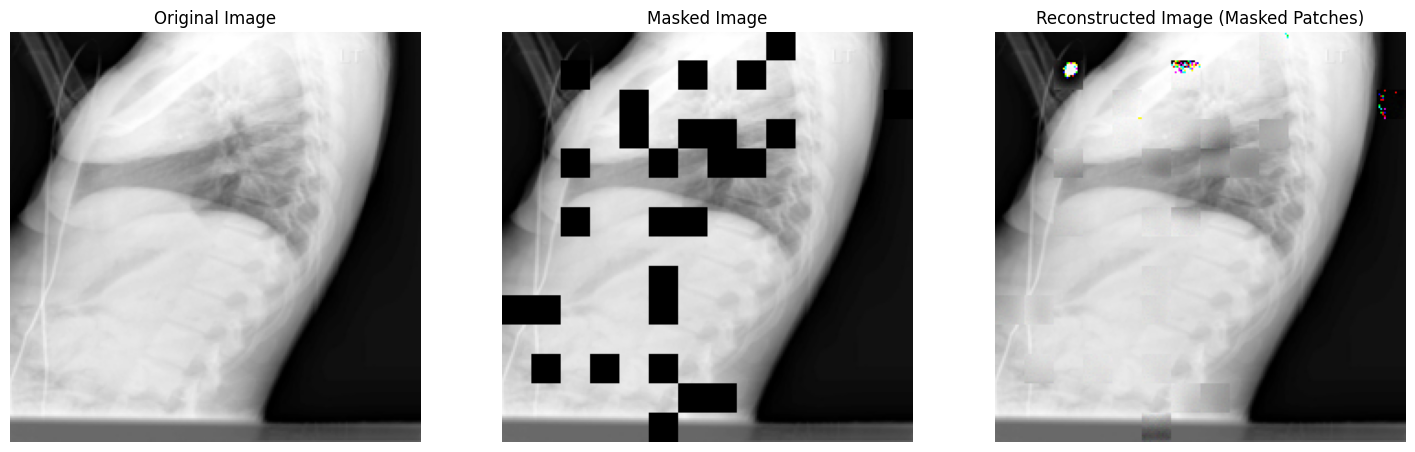

In [12]:
# Example usage
# Load a sample from the dataset (assuming dataset is an instance of ChestXrayDataset)
sample_image, _ = dataset[-1]  # Load a single image (no caption needed for MIM)

# Test the MIM model on the sample image
test_mim_model(mae_model, sample_image, device)